In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta as td

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Declare a Base using `automap_base()`
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)


In [5]:
# reflect an existing database into a new model
# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)


C:\Users\thevc\AppData\Local\Temp\ipykernel_8360\289161345.py:3: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  Base.prepare(autoload_with=engine, reflect=True)
C:\Users\thevc\AppData\Local\Temp\ipykernel_8360\289161345.py:3: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  Base.prepare(autoload_with=engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement =Base.classes.measurement
Station =Base.classes.station



In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the data set is {recent_date}.")

The most recent date in the data set is 2017-08-23.


The date one year from the last date in the data set is 2016-08-23.


<AxesSubplot:xlabel='Date', ylabel='Precipitation'>

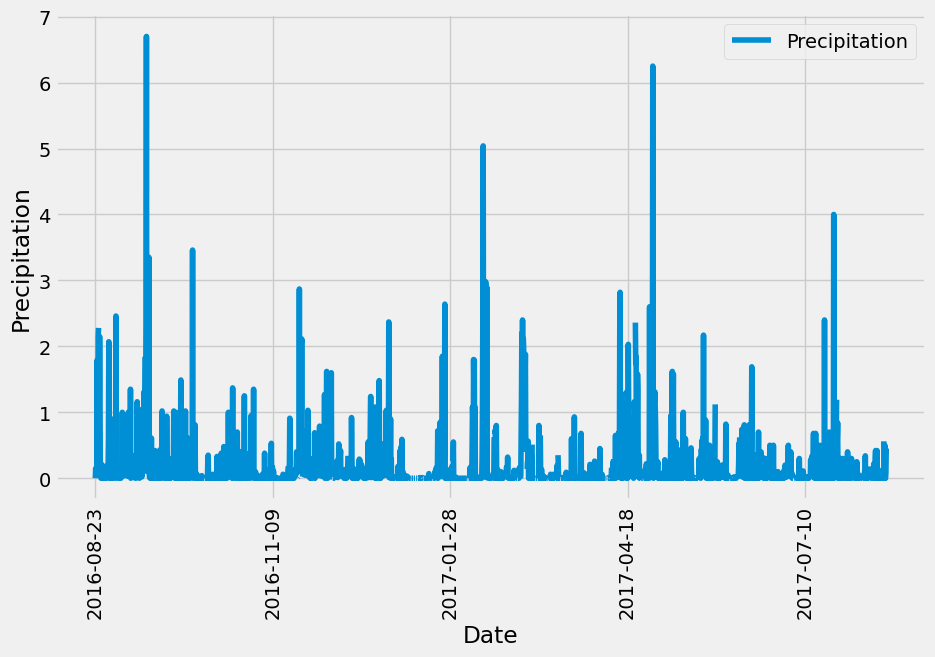

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = (dt.strptime(recent_date, '%Y-%m-%d').date() - td(days=365)).strftime('%Y-%m-%d')

print(f"The date one year from the last date in the data set is {one_year_ago}.")

# Perform a query to retrieve the data and precipitation scores

data_prec = session.query(Measurement.date, Measurement.prcp)\
                  .filter(Measurement.date >= one_year_ago)\
                  .order_by(Measurement.date)\
                  .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
p_df = pd.DataFrame(data_prec, columns=['Date', 'Precipitation'])

#set the index to the date column
p_df.set_index('Date', inplace=True)

# Sort the dataframe by date
p_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
p_df.plot(figsize=(10, 6), rot=90, legend=True, grid=True, xlabel="Date", ylabel="Precipitation")


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
p_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations=session.query(func.count(Station.station.distinct())).scalar()
print(f"There are {total_stations} stations in the dataset.")
total_stations

There are 9 stations in the dataset.


9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                         .group_by(Measurement.station)\
                         .order_by(desc(func.count(Measurement.station)))\
                         .all()

# Print the results
for station in active_stations:
    print(f"Station {station[0]} has {station[1]} rows.")


Station USC00519281 has 2772 rows.
Station USC00519397 has 2724 rows.
Station USC00513117 has 2709 rows.
Station USC00519523 has 2669 rows.
Station USC00516128 has 2612 rows.
Station USC00514830 has 2202 rows.
Station USC00511918 has 1979 rows.
Station USC00517948 has 1372 rows.
Station USC00518838 has 511 rows.


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station= session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)\
                              .filter(Measurement.station=='USC00519281')).all()
active_station

[(53.0, 87.0, 71.66378066378067)]

AttributeError: 'str' object has no attribute 'strftime'

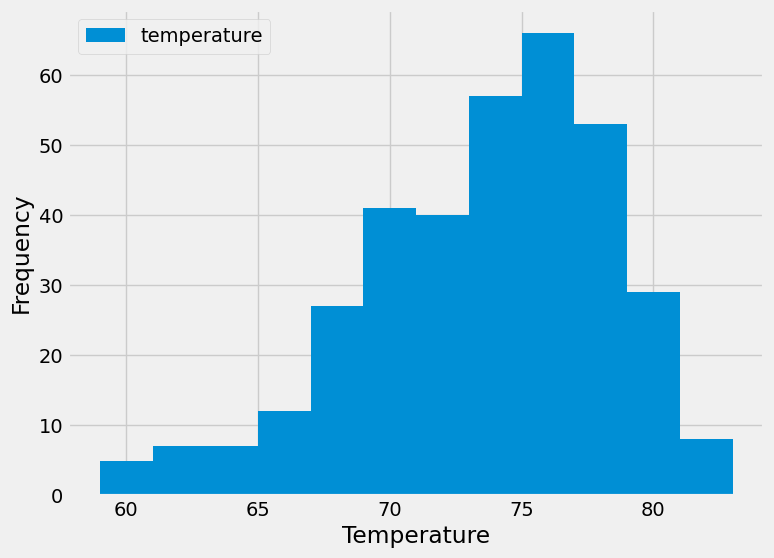

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .first()[0]
temperature_data = session.query(Measurement.tobs) \
    .filter(Measurement.date >= one_year_ago) \
    .filter(Measurement.station == most_active_station ) \
    .all()
# Convert the query results to a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])
# Convert one_year_ago to a datetime object
one_year_ago = dt.strptime(one_year_ago, '%Y-%m-%d')

# Plot the results as a histogram
temperature_df.plot.hist(bins=12, figsize=(8, 6), linewidth=0.5)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station{most_active_station}\n({one_year_ago.strftime("%Y-%m-%d")} to {recent_date})')
plt.tight_layout()
plt.show()


# Close Session

In [ ]:
# Close Session
session.close()